In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt

Suppose one has data that consists of an independent vector and a dependent vector $x_i$ and $y_i$ ($i$ is the ith value in the data set). For example:

* $x_i$ is the height of the $i$th person, and $y_i$ is their weight (predict weight using height)
* $x_i$ is a picture of a handwritten digit, and $y_i$ is the digit itself (predict numbers from hand written numbers)
* $x_i$ is a CT scan of a patient, and $y_i$ are the corresponding pixels corresponding to tumours (my research)

The goal of a neural network is as follows. Define a function $f$ that depends on parameters $a$ that makes predictions

$$\hat{y_i} =f(x_i;a)$$

One wants to make $\hat{y_i}$ (the predictions) and $y_i$ (the true values) as close as possible by modifying the values of $a$. What does as close as possible mean? This depends on the task. In general, one defines a similarity function (or **Loss** function) $L(y,\hat{y})$. The more similar all the $y_i$s and $\hat{y_i}$s are, the smaller $L$ should be. For example 1 above, this could be as simple as 

$$L(y,\hat{y}) = \sum_i(y_i-\hat{y_i})^2$$


In [2]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()

* So $x_1 = (6,2)$, $x_2=(5,2)$, ...
* So $y_1 = 1$, $y_2=5$, ...

We want to find a function $f$ that depends on parameters $a$ that lets us get from $x$ to $y$.

**Idea**: 
1. First multiply each element in $x$ by a $8 \times 2$ matrix (this is 16 parameters $a_i$)
2. Then multiply each element in $x$ by a $1 \times 8$ matrix (this is 8 parameters $a_i$)


Define a matrix (takes in a 2d vector and returns a 8d vector). 

* **IMPORTANT**: When the matrix is created, it is initially created with random values.

In [3]:
M1 = nn.Linear(2,8,bias=False)
M1

Linear(in_features=2, out_features=8, bias=False)

If one passes in a vector $x$ (the dataset) where each element $x_i$ (an instance) is a 2d vector, $M$ will apply the same matrix multiplication to each element $x_i$.

In [4]:
M1(x)

tensor([[ 5.0408,  0.2130, -2.8023,  1.5638, -1.7579, -1.9908,  1.3815,  2.5606],
        [ 4.3940,  0.2763, -2.3400,  1.3548, -1.6418, -1.4763,  1.0390,  2.1609],
        [ 2.3870,  0.8257, -0.5046,  0.6736, -1.7075,  1.1297, -0.6679,  0.6438],
        [ 8.0079,  1.3350, -3.3210,  2.3923, -3.9959, -0.3130,  0.3768,  3.2857]],
       grad_fn=<MmBackward0>)

We can chain this with a second matrix $M2$

In [5]:
M2 = nn.Linear(8,1, bias=False)
M2

Linear(in_features=8, out_features=1, bias=False)

In [6]:
M2(M1(x)).squeeze()

tensor([0.7686, 0.7502, 1.0059, 2.1036], grad_fn=<SqueezeBackward0>)

In [7]:
y

tensor([1., 5., 2., 5.])

The weights of the matrices `M1` and `M2` consitute the weights $a$ of the network defined above. In order to optimize for these weights, we first construct our network $f$ as follows:

In [8]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,8,bias=False)
        self.Matrix2 = nn.Linear(8,1,bias=False)
    def forward(self,x):
        x = self.Matrix1(x)
        x = self.Matrix2(x)
        return x.squeeze()

Constructing the network using a subclass of the `nn.Module` allows the parameters of the network to be conveniently stored. This will be useful later when we need to adjust them.

In [9]:
f = MyNeuralNet()

Pass in data to the network.

In [10]:
yhat = f(x)
yhat

tensor([0.5623, 0.6534, 1.5727, 2.6895], grad_fn=<SqueezeBackward0>)

In [11]:
y

tensor([1., 5., 2., 5.])

# Adjusting $a$ so that $\hat{y}$ and $y$ are similar

Now we define the loss function $L$, which provides a metric of similarity between $y$ and $\hat{y}$. In this case, we will use the mean squared error loss function:

In [12]:
L = nn.MSELoss()
L(y,yhat)

tensor(6.1514, grad_fn=<MseLossBackward0>)

Confirming it is doing the same as the regular mean-squared error:

In [13]:
torch.mean((y-yhat)**2)

tensor(6.1514, grad_fn=<MeanBackward0>)

Note that $L$ depends on $a$, since our predictions $\hat{y}$ depend on the parameters of the network $a$. In this sense, $L=L(a)$. **The main idea behind machine learning** is to compute

$$\frac{\partial L}{\partial a_i}$$

for each parameter $a_i$ of the network. Then we adjust each parameter as follows:

$$a_i \to a_i - \ell \frac{\partial L}{\partial a_i}$$

where $\ell$ is the learning rate.

**Example**: A loss function that only depends on one parameter:

<p align="center">
  <img src="../images/loss.PNG" alt="drawing" width="500" align="center"/>
</p>

The idea is to do this over and over again, until one reaches a minimum for $L$. This is called **gradient descent**.

* Each pass of the full data set $x$ is called an **epoch**. In this case, we are evaluating $\partial L/\partial a_i$ on the entire dataset $x$ each time we iterate $a_i \to a_i - \ell \frac{\partial L}{\partial a_i}$, so each iteration corresponds to an epoch.

The `SGD`(meaning stochastic gradient descent) takes in all model parameters $a$ along with the learning rate $\ell$.

In [14]:
opt = SGD(f.parameters(), lr=0.001)

Adjust the parameters over and over:

In [15]:
losses = []
for _ in range(50):
    opt.zero_grad() # flush previous epoch's gradient
    loss_value = L(f(x), y) #compute loss
    loss_value.backward() # compute gradient
    opt.step() # Perform iteration using gradient above
    losses.append(loss_value.item())

Plot $L(a)$ as a function of number of iterations

<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:2: SyntaxWarning: invalid escape sequence '\h'
C:\Users\vk706\AppData\Local\Temp\ipykernel_11900\3493726396.py:2: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('Loss $L(y,\hat{y};a)$')


Text(0.5, 0, 'Epochs')

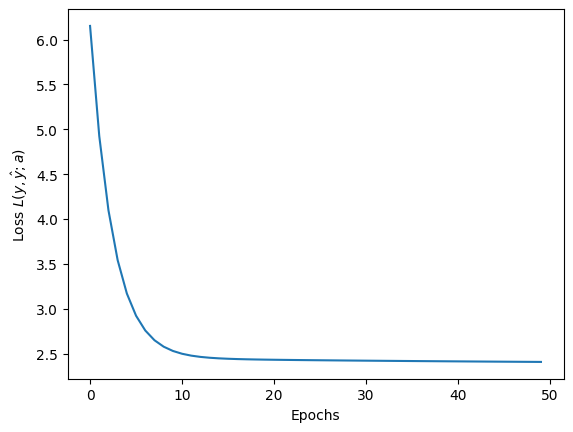

In [16]:
plt.plot(losses)
plt.ylabel('Loss $L(y,\hat{y};a)$')
plt.xlabel('Epochs')

This is as close as we can make the model $f$ predict $y$ from $x$:

In [17]:
f(x)

tensor([2.5726, 2.3638, 2.1889, 5.4214], grad_fn=<SqueezeBackward0>)

In [18]:
y

tensor([1., 5., 2., 5.])